# Deep AR implementation for sales prediction

In [1]:
# for mxnet
!pip install --upgrade mxnet
# for pytorch
!pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

!pip install --upgrade gluoncv

!pip install gluonts

     |████████████████████████████████| 47.3 MB 66 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 154.6 MB 56 kB/s 
     |████████████████████████████████| 5.1 MB 52.8 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torc

In [2]:
from gluonts.dataset import common
from gluonts.model import deepar
#from gluonts.trainer import Trainer
from gluonts.mx.trainer import Trainer

import pandas as pd
from datetime import datetime

from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model.deepar import DeepAREstimator

import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from datetime import date, timedelta
import numpy as np

from numpy import NaN
import math
import random
import re

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
PATH = '/content/drive/MyDrive/Predict_Future_Sales/'

items = pd.read_csv(PATH+'items.csv')
item_categories = pd.read_csv(PATH+'item_categories.csv')
shops = pd.read_csv(PATH+'shops.csv')
sales_train = pd.read_csv(PATH+'sales_train.csv')


###Data Transformation for Deep AR algorithm

In [5]:
#sales_train = sales_train[sales_train['item_id'] <= 3000]
sales_train['date_'] = [datetime.strptime(date,"%d.%m.%Y") for date in sales_train['date']]

In [6]:
sales_train['key'] = sales_train['date'] + sales_train['date_block_num'].astype(str) + sales_train['shop_id'].astype(str) + sales_train['item_id'].astype(str)

In [ ]:
# Aggregate to monthly level the required metrics

monthly_sales=sales_train.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})


In [7]:
sales_train['month_year'] = pd.to_datetime(sales_train['date_']).dt.to_period('M')

In [8]:
monthly_sales_df = sales_train.groupby(['month_year', 'shop_id', 'item_id'])['item_cnt_day'].sum()
monthly_sales_df = monthly_sales_df.reset_index().set_index('month_year')
monthly_sales_df['shop_item_id'] = monthly_sales_df['shop_id'].astype(str) + '_'+monthly_sales_df['item_id'].astype(str)
monthly_sales_df = monthly_sales_df.drop(columns = ['shop_id','item_id']).reset_index()
monthly_sales_df = monthly_sales_df.pivot(index = 'month_year', columns = 'shop_item_id', values = 'item_cnt_day')

In [ ]:
monthly_sales_df

shop_item_id,0_1000,0_10004,0_1001,0_10012,0_1002,0_1003,0_10033,0_10038,0_10039,0_1004,...,9_9422,9_9423,9_9424,9_9425,9_9443,9_9469,9_9532,9_9782,9_9785,9_9904
month_year,,,,,,,,,,,,,,,,,,,,,
2013-01,5.0,NaN,2.0,1.0,2.0,2.0,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02,4.0,1.0,NaN,2.0,NaN,NaN,1.0,1.0,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# This fonction converts every missing values AFTER the first non-missing value to 0
def convert_nan_to_0(col):
  col = col = col.fillna(np.nan)
  for i in range(len(col)-1):
    if np.isnan(col[i+1]) and np.isnan(col[i]):
      col[i+1] = np.nan
    elif np.isnan(col[i+1]):
      col[i+1] = 0
  return col


In [10]:
monthly_sales_df2 = monthly_sales_df.apply(convert_nan_to_0, axis = 0)

In [11]:
length = len(list(monthly_sales_df2.columns))

In [ ]:
monthly_sales_df3['26_8858']

month_year
2013-01    NaN
2013-02    NaN
2013-03    NaN
2013-04    NaN
2013-05    NaN
2013-06    NaN
2013-07    NaN
2013-08    NaN
2013-09    NaN
2013-10    NaN
2013-11    NaN
2013-12    1.0
2014-01    0.0
2014-02    0.0
2014-03    1.0
2014-04    0.0
2014-05    0.0
2014-06    0.0
2014-07    0.0
2014-08    0.0
2014-09    0.0
2014-10    0.0
2014-11    0.0
2014-12    0.0
2015-01    0.0
2015-02    0.0
2015-03    0.0
2015-04    0.0
2015-05    0.0
2015-06    0.0
2015-07    0.0
2015-08    0.0
2015-09    0.0
2015-10    0.0
Freq: M, Name: 26_8858, dtype: float64

In [12]:
cols = list(monthly_sales_df2.columns)

In [13]:
import random
random.shuffle(cols)
monthly_sales_df3 = monthly_sales_df2[cols]

In [14]:
target = monthly_sales_df3.values.transpose()
feat_static_cat = np.array([(int(monthly_sales_df3.columns[i].split('_')[1]), int(monthly_sales_df3.columns[i].split('_')[0])) for i in range(length)])
start_dates = [monthly_sales_df3.iloc[:,i].dropna().index[0].to_timestamp() for i in tqdm(range(length))]

  0%|          | 0/424124 [00:00<?, ?it/s]

In [15]:
target[0]
start_dates[0]

Timestamp('2013-01-01 00:00:00')

In [21]:
monthly_sales_df3

shop_item_id,14_15092,32_6626,7_10159,42_5738,21_10264,26_1937,47_21682,52_3716,7_9496,12_5913,...,56_13819,1_21809,16_10381,40_4964,29_15314,58_11213,2_18215,19_17852,26_15461,14_3990
month_year,,,,,,,,,,,,,,,,,,,,,
2013-01,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2013-02,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2013-03,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2013-04,0.0,0.0,1.0,NaN,1.0,9.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2013-05,0.0,0.0,1.0,NaN,0.0,5.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2013-06,0.0,0.0,0.0,NaN,0.0,3.0,NaN,NaN,NaN,NaN,...,3.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2013-07,0.0,0.0,1.0,NaN,0.0,5.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN
2013-08,0.0,0.0,0.0,NaN,0.0,2.0,NaN,NaN,NaN,NaN,...,1.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
2013-09,0.0,0.0,0.0,3.0,0.0,2.0,NaN,1.0,NaN,NaN,...,1.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,NaN


In [16]:
from gluonts.dataset.field_names import FieldName

In [17]:
pred_length = 1
frequence = "M"

In [18]:
train_ds = ListDataset(
    [
     {
      FieldName.TARGET: targ,
      FieldName.START: start,
      FieldName.FEAT_STATIC_CAT: [fsc[0],fsc[1]]
     }
     for (targ, start, fsc) in zip(
          target[:,:-pred_length],
          start_dates[:-pred_length],
          feat_static_cat,
     )
    ],
    freq = frequence
)

In [22]:

test_ds = ListDataset(
     [
     {
      FieldName.TARGET: targ,
      FieldName.START: start,
      FieldName.FEAT_STATIC_CAT: list(fsc),
     }
     for (targ, start, fsc) in zip(
          target,
          start_dates,
          feat_static_cat,
     )
    ],
    freq = frequence
)

In [49]:
start_dates[0]

Timestamp('2013-01-01 00:00:00')

In [23]:
train_entry = next(iter(train_ds))
train_entry.keys()

/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:338: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return timestamp.freq.rollforward(timestamp)


dict_keys(['target', 'start', 'feat_static_cat', 'source'])

In [24]:
test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['target', 'start', 'feat_static_cat', 'source'])

In [25]:
from gluonts.dataset.util import to_pandas

/usr/local/lib/python3.7/dist-packages/gluonts/dataset/util.py:136: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


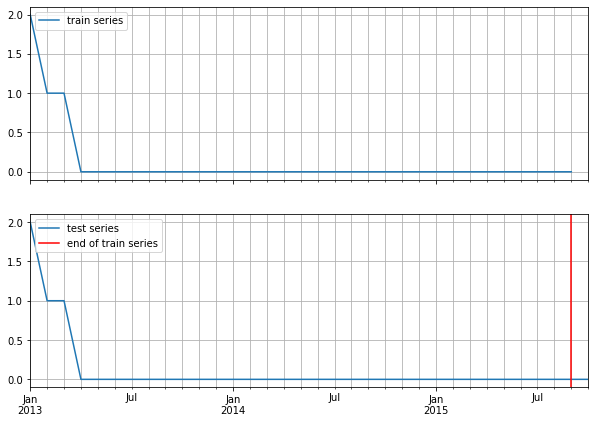

In [26]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## Transformation

In [27]:
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    SetFieldIfNotPresent,
)

In [28]:
def create_transformation(freq, context_length, prediction_length):
    return Chain(
        [
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=prediction_length,
                log_scale=True,
            ),
            InstanceSplitter(
                target_field=FieldName.TARGET,
                is_pad_field=FieldName.IS_PAD,
                start_field=FieldName.START,
                forecast_start_field=FieldName.FORECAST_START,
                instance_sampler=ExpectedNumInstanceSampler(
                    num_instances=1,
                    min_future=prediction_length,
                ),
                past_length=context_length,
                future_length=prediction_length,
                time_series_fields=[
                    FieldName.FEAT_AGE,
                    #FieldName.FEAT_DYNAMIC_REAL,
                    FieldName.OBSERVED_VALUES,
                ],
            ),
        ]
    )

In [29]:
transformation = create_transformation(
    "MS",
    12, # can be any appropriate value
    1
)

In [30]:
train_tf = transformation(iter(train_ds), is_train=True)

In [32]:
next(iter(train_tf))

/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:338: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return timestamp.freq.rollforward(timestamp)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)


{'feat_static_cat': array([10159,     7], dtype=int32),
 'forecast_start': Timestamp('2014-07-31 00:00:00', freq='M'),
 'future_feat_dynamic_age': array([[1.2787536]], dtype=float32),
 'future_observed_values': array([1.], dtype=float32),
 'future_target': array([1.], dtype=float32),
 'past_feat_dynamic_age': array([[0.845098 ],
        [0.90309  ],
        [0.9542425],
        [1.       ],
        [1.0413927],
        [1.0791812],
        [1.1139433],
        [1.146128 ],
        [1.1760913],
        [1.20412  ],
        [1.230449 ],
        [1.2552725]], dtype=float32),
 'past_is_pad': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'past_observed_values': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32),
 'past_target': array([0., 1., 0., 0., 0., 1., 0., 2., 2., 0., 1., 0.], dtype=float32),
 'source': SourceContext(source='list_data', row=2),
 'start': Timestamp('2013-02-28 00:00:00', freq='M')}

In [59]:
train_tf_entry = next(iter(train_tf))
[k for k in train_tf_entry.keys()]

/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)


['start',
 'feat_static_cat',
 'source',
 'past_feat_dynamic_age',
 'future_feat_dynamic_age',
 'past_observed_values',
 'future_observed_values',
 'past_target',
 'future_target',
 'past_is_pad',
 'forecast_start']

In [60]:
test_tf = transformation(iter(test_ds), is_train=False)

In [61]:
test_tf_entry = next(iter(test_tf))
[k for k in test_tf_entry.keys()]

/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)


['start',
 'feat_static_cat',
 'source',
 'past_feat_dynamic_age',
 'future_feat_dynamic_age',
 'past_observed_values',
 'future_observed_values',
 'past_target',
 'future_target',
 'past_is_pad',
 'forecast_start']

In [52]:
print(f"past target shape: {train_tf_entry['past_target'].shape}")
print(f"future target shape: {train_tf_entry['future_target'].shape}")
print(f"past observed values shape: {train_tf_entry['past_observed_values'].shape}")
print(f"future observed values shape: {train_tf_entry['future_observed_values'].shape}")
print(f"past age feature shape: {train_tf_entry['past_feat_dynamic_age'].shape}")
print(f"future age feature shape: {train_tf_entry['future_feat_dynamic_age'].shape}")
print(train_tf_entry['feat_static_cat'])

past target shape: (12,)
future target shape: (1,)
past observed values shape: (12,)
future observed values shape: (1,)
past age feature shape: (12, 1)
future age feature shape: (1, 1)
[5738   42]


## Training

In [53]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx import Trainer

In [81]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=1,
    context_length=2,
    freq="MS",
    trainer=Trainer(
        ctx="cpu",
        epochs=5,
        learning_rate=1e-3,
        hybridize=False,
        num_batches_per_epoch=100
    )
)

In [82]:
predictor = estimator.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
100%|██████████| 100/100 [00:01<00:00, 76.39it/s, epoch=5/5, avg_epoch_loss=-1.18]


## Evaluation

In [63]:
from gluonts.evaluation import make_evaluation_predictions

In [83]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=30,  # number of sample paths we want for evaluation
)

In [86]:
next(iter(train_ds))

{'feat_static_cat': array([15092,    14], dtype=int32),
 'source': SourceContext(source='list_data', row=0),
 'start': Timestamp('2013-01-31 00:00:00', freq='M'),
 'target': array([2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)}

In [87]:
forecasts = list(forecast_it)
tss = list(ts_it)

/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)


In [89]:
next(iter(forecast_it))

StopIteration: ignored

In [90]:
next(iter(test_ds))

{'feat_static_cat': array([15092,    14], dtype=int32),
 'source': SourceContext(source='list_data', row=0),
 'start': Timestamp('2013-01-31 00:00:00', freq='M'),
 'target': array([2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)}

In [91]:
# first entry of the time series list
ts_entry = tss[0]

In [92]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([2., 1., 1., 0., 0.], dtype=float32)

In [93]:
# first entry of test_ds
test_ds_entry = next(iter(test_ds))

In [94]:
# first 5 values
test_ds_entry['target'][:5]

array([2., 1., 1., 0., 0.], dtype=float32)

In [95]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [96]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 30
Dimension of samples: (30, 1)
Start date of the forecast window: 2015-10-31 00:00:00
Frequency of the time series: MS


In [97]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [98]:
ts_entry

,0
2013-02-01,2.0
2013-03-01,1.0
2013-04-01,1.0
2013-05-01,0.0
2013-06-01,0.0
2013-07-01,0.0
2013-08-01,0.0
2013-09-01,0.0
2013-10-01,0.0
2013-11-01,0.0


TypeError: ignored

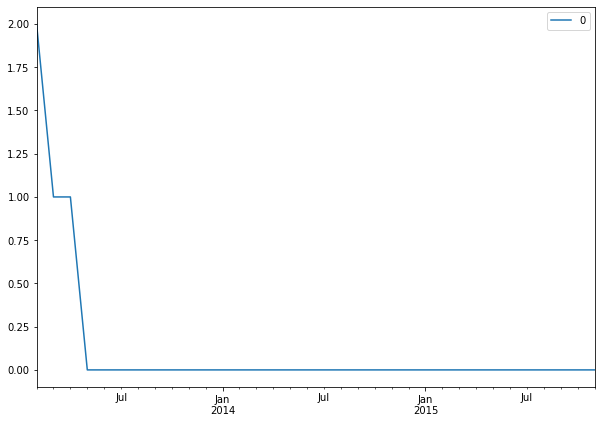

In [99]:

plot_prob_forecasts(ts_entry, forecast_entry)

## Metrics

In [100]:
from gluonts.evaluation import Evaluator

In [101]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 424124/424124 [00:00<00:00, 557476.93it/s]/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:102: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:150: RuntimeWarning: divide by zero encountered in true_divide
  return numerator / seasonal_error

/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:102: RuntimeWarning: divide by zero encoun

In [102]:
import json

In [103]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 15.88741371225029,
    "abs_error": 71261.60496472297,
    "abs_target_sum": 71076.0,
    "abs_target_mean": 0.16758306532995068,
    "seasonal_error": 0.4304252989373532,
    "MASE": Infinity,
    "MAPE": 0.9937224347869874,
    "sMAPE": 1.9980081751728282,
    "MSIS": Infinity,
    "QuantileLoss[0.1]": 15514.280512378975,
    "Coverage[0.1]": 6.601842857277589e-05,
    "QuantileLoss[0.5]": 71261.60496472297,
    "Coverage[0.5]": 0.5876206015221963,
    "QuantileLoss[0.9]": 122050.07754646544,
    "Coverage[0.9]": 0.9259273231413454,
    "RMSE": 3.98590186937038,
    "NRMSE": 23.784633975531023,
    "ND": 1.0026113591750094,
    "wQuantileLoss[0.1]": 0.21827734414400043,
    "wQuantileLoss[0.5]": 1.0026113591750094,
    "wQuantileLoss[0.9]": 1.7171770716763104,
    "mean_absolute_QuantileLoss": 69608.65434118913,
    "mean_wQuantileLoss": 0.9793552583317734,
    "MAE_Coverage": 0.0711606354116563,
    "OWA": NaN
}


## Data Visualization part 

In [ ]:
print('Our dataset has now', monthly_sales_df2.shape[0],' rows representing every months of data and ',monthly_sales_df2.shape[1], ' columns representing sales for each items in each shops')

Our dataset has now 34  rows representing every months of data and  424124  columns representing sales for each items in each shops


In [ ]:
monthly_sales_df2.head()

shop_item_id,0_1000,0_10004,0_1001,0_10012,0_1002,0_1003,0_10033,0_10038,0_10039,0_1004,...,9_9422,9_9423,9_9424,9_9425,9_9443,9_9469,9_9532,9_9782,9_9785,9_9904
month_year,,,,,,,,,,,,,,,,,,,,,
2013-01,5.0,NaN,2.0,1.0,2.0,2.0,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02,4.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
color_list = ['blue','orange','green','red','purple','brown','pink','grey','olive','cyan']

In [ ]:
def visualize(data, date_key):
  time_data = data[date_key]
  features = list(data.select_dtypes(include = [np.number]).columns.values)
  feature_size = len(features)
  fig, axes = plt.subplots(
      nrows = int(np.ceil(feature_size/5)), ncols= 2, figsize =(14, feature_size*2), dpi = 80, facecolor  ='w' , edgecolor = "k"
  )
  for i in range(feature_size):
    key = features[i]
    c= color_list[i % (len(color_list))]
    t_data = data[key]
    t_data.head()
    ax = t_data.plot(
        ax = axes[i // 2, i%2],
        color = c,
        title = "{}".format(key),
        rot = 25,)
    ax.legend([key])
    plt.tight_layout()

In [ ]:
prod_to_keep = random.sample(list(range(monthly_sales_df2.shape[1])),100)
prod_to_keep.append(0)

IndexError: ignored

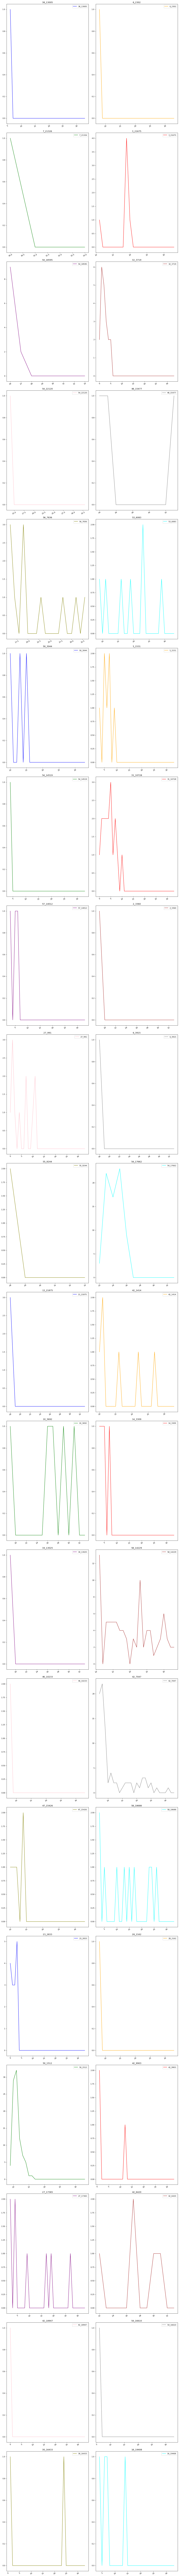

In [ ]:
visualize(monthly_sales_df2.reset_index().iloc[:,prod_to_keep],'month_year')

In [ ]:
monthly_sales_df2.head()

shop_item_id,0_1000,0_10004,0_1001,0_10012,0_1002,0_1003,0_10033,0_10038,0_10039,0_1004,...,9_9422,9_9423,9_9424,9_9425,9_9443,9_9469,9_9532,9_9782,9_9785,9_9904
month_year,,,,,,,,,,,,,,,,,,,,,
2013-01,5.0,NaN,2.0,1.0,2.0,2.0,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02,4.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
monthly_sales_df3 = monthly_sales_df2.reset_index(drop=True).T.reset_index()
ts_code = monthly_sales_df3['shop_item_id'].astype("category").cat.codes.values

In [ ]:
cat=[]
for i in range(len(list(monthly_sales_df2.columns))):
  cat.append(monthly_sales_df2.columns[i].split('_')[0])

In [ ]:
'''trainset = np.nan_to_num(monthly_sales_df3.iloc[:,1:-2].values,0)
testset = np.nan_to_num(monthly_sales_df3.iloc[:,-2:].values,0)'''
print(len(list(set(sales_train['shop_id']))))
print(len(list(set(sales_train['item_id']))))


60
21807


In [ ]:
monthly_sales_df2.iloc[33,:]

shop_item_id
0_1000     0.0
0_10004    0.0
0_1001     0.0
0_10012    0.0
0_1002     0.0
          ... 
9_9469     1.0
9_9532     0.0
9_9782     0.0
9_9785     0.0
9_9904     0.0
Name: 2015-10, Length: 424124, dtype: float64

In [ ]:
training_data = ListDataset(
    [
     {'start':  monthly_sales_df2.iloc[:33,i].dropna().index[0].to_timestamp(), 'target':monthly_sales_df2.iloc[:33,i].dropna(),'feat_static_cat':[monthly_sales_df2.columns[i].split('_')[0],monthly_sales_df2.columns[i].split('_')[1]]}
     for i in tqdm(range(len(list(monthly_sales_df2.columns))))
    ]
    , freq = 'm')

  0%|          | 0/424124 [00:00<?, ?it/s]

In [ ]:
freq = 'm'
#start_train = monthly_sales_df2.index[0].to_timestamp(freq= freq)
#start_test =  monthly_sales_df2.index[-2].to_timestamp(freq= freq)
context_length = 12
prediction_length = 1

estimator = DeepAREstimator(freq = freq,
                            context_length = context_length,
                            prediction_length = prediction_length,
                            use_feat_static_cat= True,
                            cardinality  = [60,21807],
                            num_layers = 2,
                            num_cells = 40,
                            cell_type = 'lstm',
                            trainer = Trainer(epochs = 5)
                            )

In [ ]:
predictor = estimator.train(training_data= training_data)

/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base = start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be remove

In [ ]:
test_data = ListDataset(
    [
     {'start':  monthly_sales_df2.iloc[33:,i].index[0].to_timestamp(), 'target':monthly_sales_df2.iloc[33:,i].values,'feat_static_cat':[monthly_sales_df2.columns[i].split('_')[0],monthly_sales_df2.columns[i].split('_')[1]]}
     for i in tqdm(range(len(list(monthly_sales_df2.columns))))
    ]
    , freq = 'm')

  0%|          | 0/424124 [00:00<?, ?it/s]

In [ ]:
monthly_sales_df2.columns[-1].split('_')[0]

'9'

In [ ]:
'''train_ds = ListDataset([
                        {FieldName.TARGET : target,
                         FieldName.START: start_train,
                         FieldName.FEAT_STATIC_CAT:fsc,
                         FieldName.FEAT_STATIC_CAT
                         }
                        for (target,fsc) in zip(trainset, ts_code.reshape(-1,1))
                        ], freq = freq)

test_ds = ListDataset([
                        {FieldName.TARGET : target,
                         FieldName.START: start_test,
                         FieldName.FEAT_STATIC_CAT:fsc
                         }
                        for (target,fsc) in zip(testset, ts_code.reshape(-1,1))
                        ], freq = freq)'''

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset = test_data,
    predictor = predictor
)

In [ ]:
print('Obtaining time series conditioning values ...')
tss = list(tqdm(ts_it, total = len(test_data)))
print('Obtaining time series predictions ...')
forecasts = list(tqdm(forecast_it, total = len(test_data)))

Obtaining time series conditioning values ...


  0%|          | 0/424124 [00:00<?, ?it/s]

In [ ]:
#tss[-200:-100]
forecasts[-200:-100]

/usr/local/lib/python3.7/dist-packages/gluonts/core/serde/pd.py:31: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  "kwargs": {"freq": v.freqstr if v.freq else None},
/usr/local/lib/python3.7/dist-packages/gluonts/core/serde/pd.py:31: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  "kwargs": {"freq": v.freqstr if v.freq else None},


[gluonts.model.forecast.SampleForecast(freq="m", info=None, item_id=None, samples=numpy.array([[-6.310030189332627e-12], [-3.1256542493141026e-12], [-9.402161341154347e-12], [-3.814856416872736e-11], [1.9734344366972856e-11], [5.53657432400545e-11], [1.988076717140963e-11], [-9.17773062408811e-12], [2.287996320182728e-10], [7.955421911509664e-12], [3.8022533038750694e-11], [7.658544805277945e-12], [-3.798512719643821e-12], [-2.1481442926546412e-12], [4.9939989643643656e-11], [1.5867019503845725e-11], [-3.084702285272023e-11], [-2.583098882361079e-12], [-8.082576274937026e-12], [-7.371155075208691e-11], [-3.990698049793906e-11], [-5.7218670773684366e-11], [-6.378186607342018e-12], [1.7694243639732044e-11], [-2.2129296659012532e-11], [-2.0976836587194292e-11], [1.0362910182748486e-11], [4.9744937336004824e-11], [6.44472973251875e-13], [1.7427673887349115e-11], [1.0700908908978235e-11], [2.8102523780271227e-11], [2.770780653527094e-11], [1.4000649598000514e-11], [-4.054956370680429e-11], 

In [ ]:
def plot_prob_forecast(ts_entry, forecast_entry):
  plot_length = prediction_length
  prediction_intervals = (80.0 ,95.0)
  legend = ['Observations' , 'median projection'] + [f"{k}% prediction interval" for k in prediction_intervals[::1]]

  fig, ax = plt.subplots(1,1 ,figsize = (10,7))
  ts_entry[-plot_length:].plot(ax = ax)
  forecast_entry.plot(prediction_intervals = prediction_intervals, color ='g')
  plt.grid(which ='both')
  plt.legend(legend,  loc = 'upper left')
  plt.show()


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:1200: UserWarning: Attempting to set identical left == right == 549.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:1200: UserWarning: Attempting to set identical left == right == 549.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


TypeError: ignored

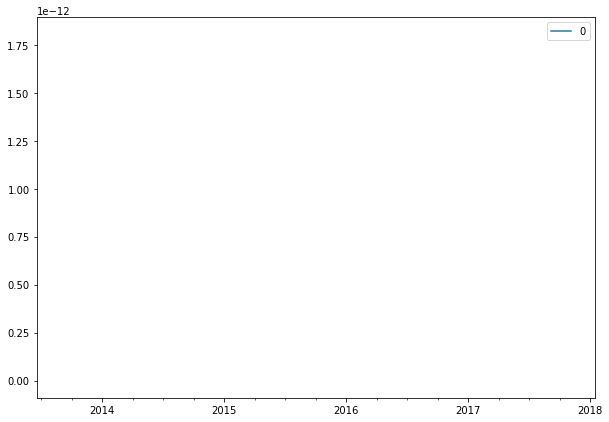

In [ ]:
for i in tqdm(range(200,210)):
  ts_entry = tss[i]
  forecast_entry = forecasts[i]
  plot_prob_forecast(ts_entry, forecast_entry)

In [ ]:
forecasts[5]


/usr/local/lib/python3.7/dist-packages/gluonts/core/serde/pd.py:31: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  "kwargs": {"freq": v.freqstr if v.freq else None},
/usr/local/lib/python3.7/dist-packages/gluonts/core/serde/pd.py:31: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  "kwargs": {"freq": v.freqstr if v.freq else None},


gluonts.model.forecast.SampleForecast(freq="m", info=None, item_id=None, samples=numpy.array([[-8.385446200256941e-13], [-3.842952345234352e-11], [-2.2809916455646118e-10], [1.477487923673415e-11], [-1.145730559037883e-11]], numpy.dtype("float32")), start_date=pandas.Timestamp("2015-10-31 00:00:00", freq="M"))

In [ ]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles = [0.1, 0.5,0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series = len(testset))

Running evaluation: 100%|██████████| 424124/424124 [00:00<00:00, 433712.97it/s]/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:102: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:102: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:150: RuntimeWarnin

In [ ]:
agg_metrics

{'Coverage[0.1]': 0.00016268827041148343,
 'Coverage[0.5]': 0.05937650309815054,
 'Coverage[0.9]': 0.9257882128811386,
 'MAE_Coverage': 0.1887496738375255,
 'MAPE': 1.0,
 'MASE': nan,
 'MSE': 16.079703105695504,
 'MSIS': nan,
 'ND': 1.0000000000436626,
 'NRMSE': 23.928136794321244,
 'OWA': nan,
 'QuantileLoss[0.1]': 14231.20000366414,
 'QuantileLoss[0.5]': 71076.00000310337,
 'QuantileLoss[0.9]': 127920.8000024571,
 'RMSE': 4.009950511626734,
 'abs_error': 71076.00000310337,
 'abs_target_mean': 0.16758306532995068,
 'abs_target_sum': 71076.0,
 'mean_absolute_QuantileLoss': 71076.00000307486,
 'mean_wQuantileLoss': 1.0000000000432616,
 'sMAPE': 2.0,
 'seasonal_error': nan,
 'wQuantileLoss[0.1]': 0.20022511120018205,
 'wQuantileLoss[0.5]': 1.0000000000436626,
 'wQuantileLoss[0.9]': 1.7997748888859404}

In [ ]:
for i in range(len(item_metrics)):
  print(item_metrics.index[i])
  print(item_metrics['MSE'][i])

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1000
2.0618629957513597e-08
1001
2.216040867654468e-08
1002
1.068434123167648e-06
1003
2.4545023103611687e-08
1004
1.5640728912741555e-08
1005
2.501352289454512e-08
1006
0.032340715008397254
1007
2.2273483072269535e-08
1008
0.03227840700457173
1009
3.071969998810316e-08
1010
2.2006203483127344e-08
1011
2.0792743183142927e-08
1012
1.8253105750890458e-08
1013
2.196103130171973e-08
1014
2.1908634505140774e-08
1015
4.59915811241503e-08
1016
0.0647692911086544
1017
2.1065034161438234e-08
1018
1.307569824172289e-07
1019
0.06486222051805066
1020
5.305260386986417e-07
1021
2.074269163600665e-08
1022
3.0433937119537845e-08
1023
5.075123461269428e-09
1024
3.6663414287050405e-06
1025
2.8498437924070225e-06
1026
2.749499887408268e-06
1027
0.9976397483579574
1028
3.4048205106368947e-06
1029
3.056787752411178e-06
1030
2.483542375337551e-09
1031
1.2253368155260461e-08
1032
0.03228360991324148
1033
3.2501284881765323e-06
103

In [ ]:
sample_submission = pd.read_csv(PATH+'sample_submission.csv')

In [ ]:
input_df.iloc[100:150,900:]

,899,900,901,902,903,904,905,906,907,908,...,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
